In [58]:
import json, pickle
from collections import Counter
import warnings

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.base import clone

from scipy.stats.stats import spearmanr
from scipy.stats.stats import kendalltau
from tqdm import tqdm

import pickle
from joblib import dump, load
from scipy.sparse import vstack, hstack
from sklearn.metrics import roc_auc_score


warnings.filterwarnings("ignore")

# Данные

Считывание и подготовка данных

In [93]:
players = pickle.load(open('chgk/players.pkl', 'rb'))
tournaments = pickle.load(open('chgk/tournaments.pkl', 'rb'))

In [94]:
players = pd.DataFrame(players.values()).set_index("id")
players.head()

,name,patronymic,surname
id,,,
1,Алексей,None,Абабилов
10,Игорь,,Абалов
11,Наталья,Юрьевна,Абалымова
12,Артур,Евгеньевич,Абальян
13,Эрик,Евгеньевич,Абальян


In [61]:
tournaments = pd.DataFrame(tournaments.values()).set_index("id")
tournaments.head()

,name,dateStart,dateEnd,type,season,orgcommittee,synchData,questionQty
id,,,,,,,,
1,Чемпионат Южного Кавказа,2003-07-25T00:00:00+04:00,2003-07-27T00:00:00+04:00,"{'id': 2, 'name': 'Обычный'}",/seasons/1,[],None,None
2,Летние зори,2003-08-09T00:00:00+04:00,2003-08-09T00:00:00+04:00,"{'id': 2, 'name': 'Обычный'}",/seasons/1,[],None,None
3,Турнир в Ижевске,2003-11-22T00:00:00+03:00,2003-11-24T00:00:00+03:00,"{'id': 2, 'name': 'Обычный'}",/seasons/2,[],None,None
4,Чемпионат Украины. Переходной этап,2003-10-11T00:00:00+04:00,2003-10-12T00:00:00+04:00,"{'id': 2, 'name': 'Обычный'}",/seasons/2,[],None,None
5,Бостонское чаепитие,2003-10-10T00:00:00+04:00,2003-10-13T00:00:00+04:00,"{'id': 2, 'name': 'Обычный'}",/seasons/2,[],None,None


In [62]:
assert (tournaments.index.value_counts() > 1).sum() == 0, 'Турниры повторяются'

In [63]:
tournaments['dateStart'] = pd.to_datetime(tournaments.dateStart, utc=True)
tournaments = tournaments[tournaments.dateStart.dt.year >= 2019]
print(tournaments.shape)
train_tournaments = tournaments[tournaments.dateStart.dt.year == 2019]
test_tournaments = tournaments[tournaments.dateStart.dt.year == 2020]
print(train_tournaments.shape, test_tournaments.shape)

(1109, 8)
(689, 8) (416, 8)


In [64]:
results = pickle.load(open('chgk/results.pkl', 'rb'))

Выделим дополнительную информацию в удобный вид:
1) команды и их ответы на турнирах
2) составы команд

results[tournament_id]['team']['teamMembers']['player']['id'] - участники   
results[tournament_id]['team']['mask'] - ответы, 1 - верно, 0 - неверно  
results[tournament_id]['team']['id'] - id команды

In [65]:
# Соберём статистики:
add_info = []
for tournament_id in tournaments.index:
    tournament = results.get(tournament_id)
    if tournament:
        for team in tournament:
            if team.get('team'):
                team_id = team['team'].get('id', None)
                if team.get('teamMembers', None):
                    team_members = [member.get('player', None) for member in team['teamMembers']]
                    team_members = [member for member in team_members if member]
                    team_members = [member.get('id', None) for member in team_members if member]
                    team_members = [member for member in team_members if member]
                else:
                    team_members = None
                
                
                add_info.append([
                    tournament_id, 
                    team_id, 
                    team.get('mask', None), 
                    team_members
                ])
                
tournament_add_info = pd.DataFrame(add_info, columns=['tournament_id', 'team_id', 'mask', 'team_member_ids'])
tournament_add_info.head()

,tournament_id,team_id,mask,team_member_ids
0,4772,45556,111111111011111110111111111100010010,"[6212, 18332, 18036, 22799, 15456, 26089]"
1,4772,1030,111111111011110100101111011001011010,"[1585, 40840, 1584, 10998, 16206]"
2,4772,4252,111111111011110101101111001011110000,"[23513, 18168, 21060, 35850, 31332, 10187]"
3,4772,5444,101111101111111110001101011001111010,"[36742, 28939, 54289, 15381, 27375]"
4,4772,40931,111111101011111101000111001001111110,"[28689, 17720, 30597, 12400, 26988, 69476]"


In [66]:
team_tournament_results = tournaments.reset_index().merge(tournament_add_info.rename(columns={'tournament_id': 'id'}), on='id')
team_tournament_results.head()

,id,name,dateStart,dateEnd,type,season,orgcommittee,synchData,questionQty,team_id,mask,team_member_ids
0,4772,Синхрон северных стран. Зимний выпуск,2019-01-05 16:00:00+00:00,2019-01-09T19:00:00+03:00,"{'id': 3, 'name': 'Синхрон'}",/seasons/52,"[{'id': 28379, 'name': 'Константин', 'patronym...",{'dateRequestsAllowedTo': '2019-01-09T23:59:59...,"{'1': 12, '2': 12, '3': 12}",45556,111111111011111110111111111100010010,"[6212, 18332, 18036, 22799, 15456, 26089]"
1,4772,Синхрон северных стран. Зимний выпуск,2019-01-05 16:00:00+00:00,2019-01-09T19:00:00+03:00,"{'id': 3, 'name': 'Синхрон'}",/seasons/52,"[{'id': 28379, 'name': 'Константин', 'patronym...",{'dateRequestsAllowedTo': '2019-01-09T23:59:59...,"{'1': 12, '2': 12, '3': 12}",1030,111111111011110100101111011001011010,"[1585, 40840, 1584, 10998, 16206]"
2,4772,Синхрон северных стран. Зимний выпуск,2019-01-05 16:00:00+00:00,2019-01-09T19:00:00+03:00,"{'id': 3, 'name': 'Синхрон'}",/seasons/52,"[{'id': 28379, 'name': 'Константин', 'patronym...",{'dateRequestsAllowedTo': '2019-01-09T23:59:59...,"{'1': 12, '2': 12, '3': 12}",4252,111111111011110101101111001011110000,"[23513, 18168, 21060, 35850, 31332, 10187]"
3,4772,Синхрон северных стран. Зимний выпуск,2019-01-05 16:00:00+00:00,2019-01-09T19:00:00+03:00,"{'id': 3, 'name': 'Синхрон'}",/seasons/52,"[{'id': 28379, 'name': 'Константин', 'patronym...",{'dateRequestsAllowedTo': '2019-01-09T23:59:59...,"{'1': 12, '2': 12, '3': 12}",5444,101111101111111110001101011001111010,"[36742, 28939, 54289, 15381, 27375]"
4,4772,Синхрон северных стран. Зимний выпуск,2019-01-05 16:00:00+00:00,2019-01-09T19:00:00+03:00,"{'id': 3, 'name': 'Синхрон'}",/seasons/52,"[{'id': 28379, 'name': 'Константин', 'patronym...",{'dateRequestsAllowedTo': '2019-01-09T23:59:59...,"{'1': 12, '2': 12, '3': 12}",40931,111111101011111101000111001001111110,"[28689, 17720, 30597, 12400, 26988, 69476]"


# Baseline-модель

Постройте baseline-модель на основе линейной или логистической регрессии, которая будет обучать рейтинг-лист игроков. Замечания и подсказки:  
1) повопросные результаты — это фактически результаты броска монетки, и их предсказание скорее всего имеет отношение к бинарной классификации;
2) в разных турнирах вопросы совсем разного уровня сложности, поэтому модель должна это учитывать; скорее всего, модель должна будет явно обучать не только силу каждого игрока, но и сложность каждого вопроса;
3) для baseline-модели можно забыть о командах и считать, что повопросные результаты команды просто относятся к каждому из её игроков.


Для модели нужно приготовить следующие факторы:  
1) тип турнира  
2) номер вопроса
3) участник

В качестве целевой переменной будем использовать ответы на эти вопросы.

Cначала построим бейзлайн, где мы будем обучать силу игрока, а также сложность каждого вопроса. В итоге мы получим веса для каждого игрока, которые показывают силу игрока, а также веса для вопросов, которые показывают их сложность.

## Подготовка данных

In [67]:
players_from_tournaments = pd.to_numeric(team_tournament_results['team_member_ids'].explode().dropna()).sort_values().unique()

In [68]:
# Кодируем каждого вопрос и игрока
team_tournament_results['type_id'] = team_tournament_results['type'].apply(lambda x: x['id'])
team_tournament_results['mask'] = team_tournament_results['mask'].apply(lambda x: [i for i in enumerate(x)] if x else [])
team_tournament_results[['id', 'mask', 'type_id', 'team_member_ids']]

tournaments_by_question = team_tournament_results[['id', 'mask', 'type_id', 'team_member_ids']]\
    .explode(column='mask')\
    .explode(column='team_member_ids')\
    .dropna(subset=['mask', 'team_member_ids'])
tournaments_by_question['num'] = tournaments_by_question['mask'].apply(lambda x: x[0])
tournaments_by_question['answer'] = tournaments_by_question['mask'].apply(lambda x: x[1])
tournaments_by_question = tournaments_by_question.drop(columns=['mask'])

tournament_vectorizer = OneHotEncoder()
tournament_vectorizer = tournament_vectorizer.fit(
    (tournaments_by_question['type_id'].astype(str) + '_' + tournaments_by_question['num'].astype(str))\
    .values.reshape(-1, 1)
)

player_vectorizer = OneHotEncoder()
player_vectorizer = player_vectorizer.fit(tournaments_by_question[['team_member_ids']].astype(str))

tournaments_by_question.head()

,id,type_id,team_member_ids,num,answer
0,4772,3,6212,0,1
0,4772,3,18332,0,1
0,4772,3,18036,0,1
0,4772,3,22799,0,1
0,4772,3,15456,0,1


In [69]:
tournaments_by_question = tournaments_by_question[tournaments_by_question['answer'].isin(['0', '1'])]
tournaments_by_question['answer'] = pd.to_numeric(tournaments_by_question['answer'])

In [70]:
train_data = tournaments_by_question[tournaments_by_question['id'].isin(train_tournaments.index.unique())]
test_data = tournaments_by_question[tournaments_by_question['id'].isin(test_tournaments.index.unique())]

In [16]:
# del tournaments_by_question, tournament_add_info, team_tournament_results, players_from_tournaments

In [17]:
# del train_tournaments, test_tournaments

In [18]:
# del results, tournaments, players

In [19]:
tournament_train_arr = tournament_vectorizer.transform(
    (train_data['type_id'].astype(str) + '_' + train_data['num'].astype(str))\
    .values.reshape(-1, 1)
)

player_train_arr = player_vectorizer.transform(train_data[['team_member_ids']].astype(str))

tournament_test_arr = tournament_vectorizer.transform(
    (test_data['type_id'].astype(str) + '_' + test_data['num'].astype(str))\
    .values.reshape(-1, 1)
)

player_test_arr = player_vectorizer.transform(test_data[['team_member_ids']].astype(str))

In [20]:
X_train = hstack([tournament_train_arr, player_train_arr])
X_test = hstack([tournament_test_arr, player_test_arr])

y_train = train_data['answer']
y_test = test_data['answer']

In [21]:
data = (X_train, X_test, y_train, y_test)

with open('baseline_data.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [22]:
del data, player_test_arr, tournament_test_arr, player_train_arr, tournament_train_arr

In [23]:
del train_data, test_data

## Моделирование

In [24]:
with open('baseline_data.pickle', 'rb') as handle:
    X_train, X_test, y_train, y_test = pickle.load(handle)

In [25]:
clf = LogisticRegression(solver='saga', random_state=0, n_jobs=-1)
clf = clf.fit(X_train, y_train)

In [56]:
train_score = roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])
test_score = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print(f'Train roc_auc: {train_score}, test roc_auc: {test_score}')

Train roc_auc: 0.6840039119925074, test roc_auc: 0.6361884868289892


In [26]:
dump(clf, 'baseline_model.joblib')

['baseline_model.joblib']

In [25]:
clf = load('baseline_model.joblib')

In [86]:
baseline_results = pd.DataFrame(
    zip(
        tournament_vectorizer.categories_[0].tolist() +  player_vectorizer.categories_[0].tolist(), 
        clf.coef_[0].tolist()
    ),
    columns=['name', 'strength']
)

In [87]:
baseline_results.head()

,name,strength
0,2_0,0.267513
1,2_1,-0.029839
2,2_10,-0.463820
3,2_100,-0.200303
4,2_101,-1.308484


In [88]:
baseline_results.tail()

,name,strength
64798,99962,0.562643
64799,9997,1.047116
64800,99975,-0.000321
64801,99986,0.975008
64802,99988,-0.269391


Посчитаем количество турниров, в которых участовал игрок

In [113]:
# Убирааем тех, кто не участвовал и не отвечал
tournaments_cnt = tournaments_by_question.groupby('team_member_ids').size().reset_index().rename(columns={'team_member_ids': 'id', 0: 'count'})
answer_cnt = tournaments_by_question.groupby('team_member_ids')[['answer']].sum().reset_index().rename(columns={'team_member_ids': 'id'})
players_strenght = baseline_results.iloc[tournament_vectorizer.categories_[0].shape[0]:].rename(columns={'name': 'id'})
players_strenght['id'] = pd.to_numeric(players_strenght['id'])
players_rating = players.reset_index()\
    .merge(tournaments_cnt, on='id', how='inner')\
    .merge(answer_cnt, on='id', how='left') \
    .merge(players_strenght, on='id', how='left')\
    .fillna(0)

In [114]:
players_rating.sort_values('strength', ascending=False).head(25)

,id,name,patronymic,surname,count,answer,strength
5311,36844,Павел,Константинович,Щербина,72,70,2.887239
3976,27403,Максим,Михайлович,Руссо,2974,2376,2.325236
620,4270,Александра,Владимировна,Брутер,3440,2760,2.298403
57453,217804,Алибек,,Аубакиров,45,37,2.290192
57452,217803,Дамир,,Тужушев,45,37,2.290184
4494,31021,Алина,Леонидовна,Сухотина,116,94,2.263107
10013,90527,Дмитрий,Олегович,Вальтер,36,30,2.255844
36543,195091,Ольга,Фёдоровна,Остросаблина,36,30,2.255844
12074,108232,Георгий,Александрович,Корнеев,36,31,2.253994
58254,218653,Ержан,,Юсупов,72,57,2.253994


Посмотрим лучших игороков, и в своём рейтинге отфильтруем тех, кто играет часто.
Топы пересакаются, что говорит нам о том, что рейтинг система работает.
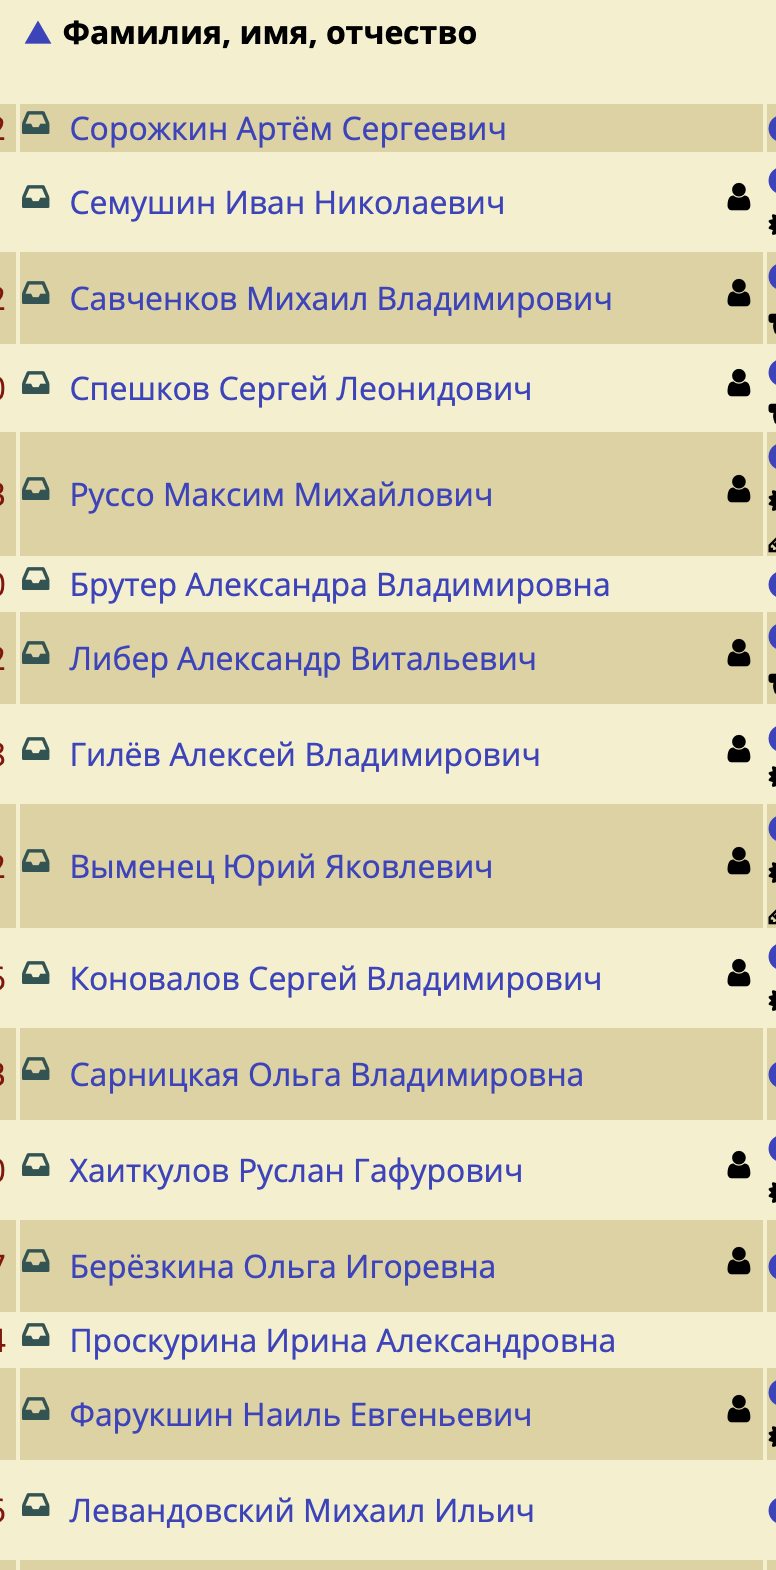

In [121]:
players_rating[players_rating['count'] > players_rating['count'].quantile(0.5)].sort_values('strength', ascending=False).head(25)

,id,name,patronymic,surname,count,answer,strength
3976,27403,Максим,Михайлович,Руссо,2974,2376,2.325236
620,4270,Александра,Владимировна,Брутер,3440,2760,2.298403
4494,31021,Алина,Леонидовна,Сухотина,116,94,2.263107
4172,28751,Иван,Николаевич,Семушин,4715,3729,2.249464
53385,213352,Владимир,Олегович,Кононов,279,159,2.195161
61475,222188,Арина,,Гринко,252,209,2.157516
4051,27822,Михаил,Владимирович,Савченков,4327,3353,2.156209
6832,55040,Владимир,Анатольевич,Гусаров,135,102,2.153213
4386,30270,Сергей,Леонидович,Спешков,5146,3928,2.129862
61637,222388,Александр,Владимирович,Карпов,285,162,2.126431
